# Inspect prediction results from a CNN

In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import pickle
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
import read_settings

Set input and output directories

In [16]:
# Read settings
global_settings = read_settings.check_global()
instrument = global_settings['input_data']['instrument']
cnn_settings = read_settings.check_cnn()
use_weights = cnn_settings['data']['use_weights']

# Directory for input data
data_dir = os.path.join('data', instrument)

# Directory for training outputs
output_dirs = glob.glob(os.path.join('output', '_'.join(['cnn', 'w' if use_weights else 'nw', instrument, '*'])))
output_dirs

['output/cnn_nw_zooscan_20210106-150033-650617']

Choose output directory to inspect

In [17]:
output_dir = output_dirs[0]

Glimpse at settings

In [18]:
with open(os.path.join(output_dir, 'settings.pickle'),'rb') as settings_file:
    settings = pickle.load(settings_file)
settings

{'global_settings': {'random_state': 12,
  'input_data': {'instrument': 'zooscan',
   'split': [70, 15, 15],
   'n_max': None}},
 'cnn_settings': {'data': {'batch_size': 32,
   'px_del': 31,
   'preserve_size': False,
   'augment': True,
   'use_weights': False},
  'architecture': {'fc_layers_nb': 1,
   'fc_layers_size': 680,
   'fc_layers_dropout': 0.5,
   'classif_layer_dropout': 0.5,
   'train_fe': True},
  'compilation': {'lr_method': 'constant',
   'initial_lr': 0.001,
   'decay_rate': 0.97,
   'loss': 'cce'},
  'training': {'epochs': 50}}}

## Input data

In [19]:
df_comp = pd.read_csv(os.path.join(output_dir, 'df_comp.csv')).set_index('classif_id')

<Figure size 432x288 with 0 Axes>

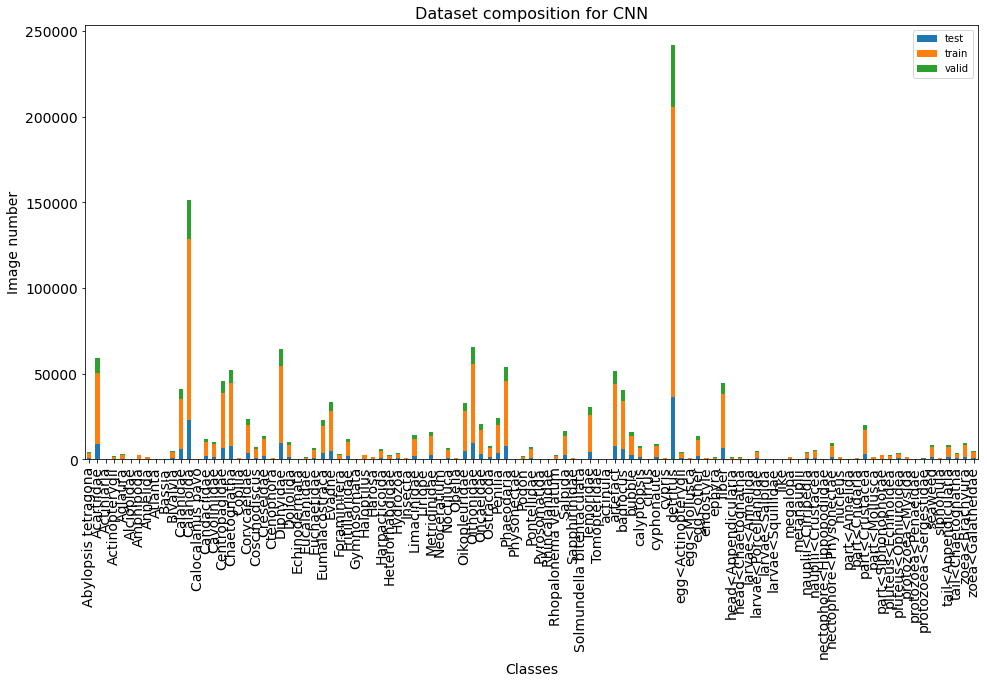

In [20]:
plt.figure()
df_comp.plot.bar(stacked=True, figsize=(16,8), fontsize = 14)
plt.xlabel("Classes", fontsize = 14)
plt.ylabel("Image number", fontsize = 14)
plt.legend(loc="best")
plt.title("Dataset composition for CNN", fontsize = 16)
plt.show()

## Training

Read training file

In [21]:
with open(os.path.join(output_dir, 'train_results.pickle'),'rb') as results_file:
    train_results = pickle.load(results_file)
    
    train_acc = train_results.get('accuracy')
    val_acc = train_results.get('val_accuracy')
    
    train_loss = train_results.get('loss')
    val_loss = train_results.get('val_loss')

In [22]:
weights = glob.glob(os.path.join(output_dir, '*.hdf5'))
weights.sort()
best_epoch = int(os.path.basename(weights[-1]).split('.')[1])-1

Plot training evolution

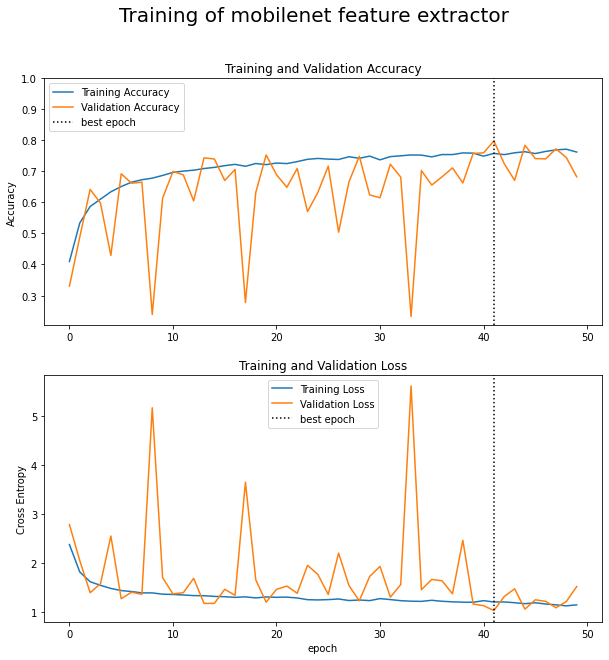

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(best_epoch, color = 'k', ls='dotted', label='best epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(best_epoch, color = 'k', ls='dotted', label='best epoch')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.suptitle('Training of mobilenet feature extractor', fontsize=20)
plt.show()

## Testing

Read test file

In [24]:
with open(os.path.join(output_dir, 'test_results.pickle'),'rb') as results_file:
    test_results = pickle.load(results_file)
    
    true_classes = test_results.get('true_classes')
    predicted_classes = test_results.get('predicted_classes')
    classes = test_results.get('classes')
    living_classes = test_results.get('living_classes')
    
    accuracy = test_results.get('accuracy')
    balanced_accuracy = test_results.get('balanced_accuracy')
    
    living_precision = test_results.get('living_precision')
    living_recall = test_results.get('living_recall')

### Accuracy scores

In [25]:
print(f'Accuracy score is {accuracy}')
print(f'Balanced accuracy score is {balanced_accuracy}')
print(f'Living precision score is {living_precision}')
print(f'Living recall score is {living_recall}')

Accuracy score is 0.7973785042864625
Balanced accuracy score is 0.5145831681918985
Living precision score is 0.8485589812332439
Living recall score is 0.8164851252087888


### Confusion matrix

Plot a confusion matrix

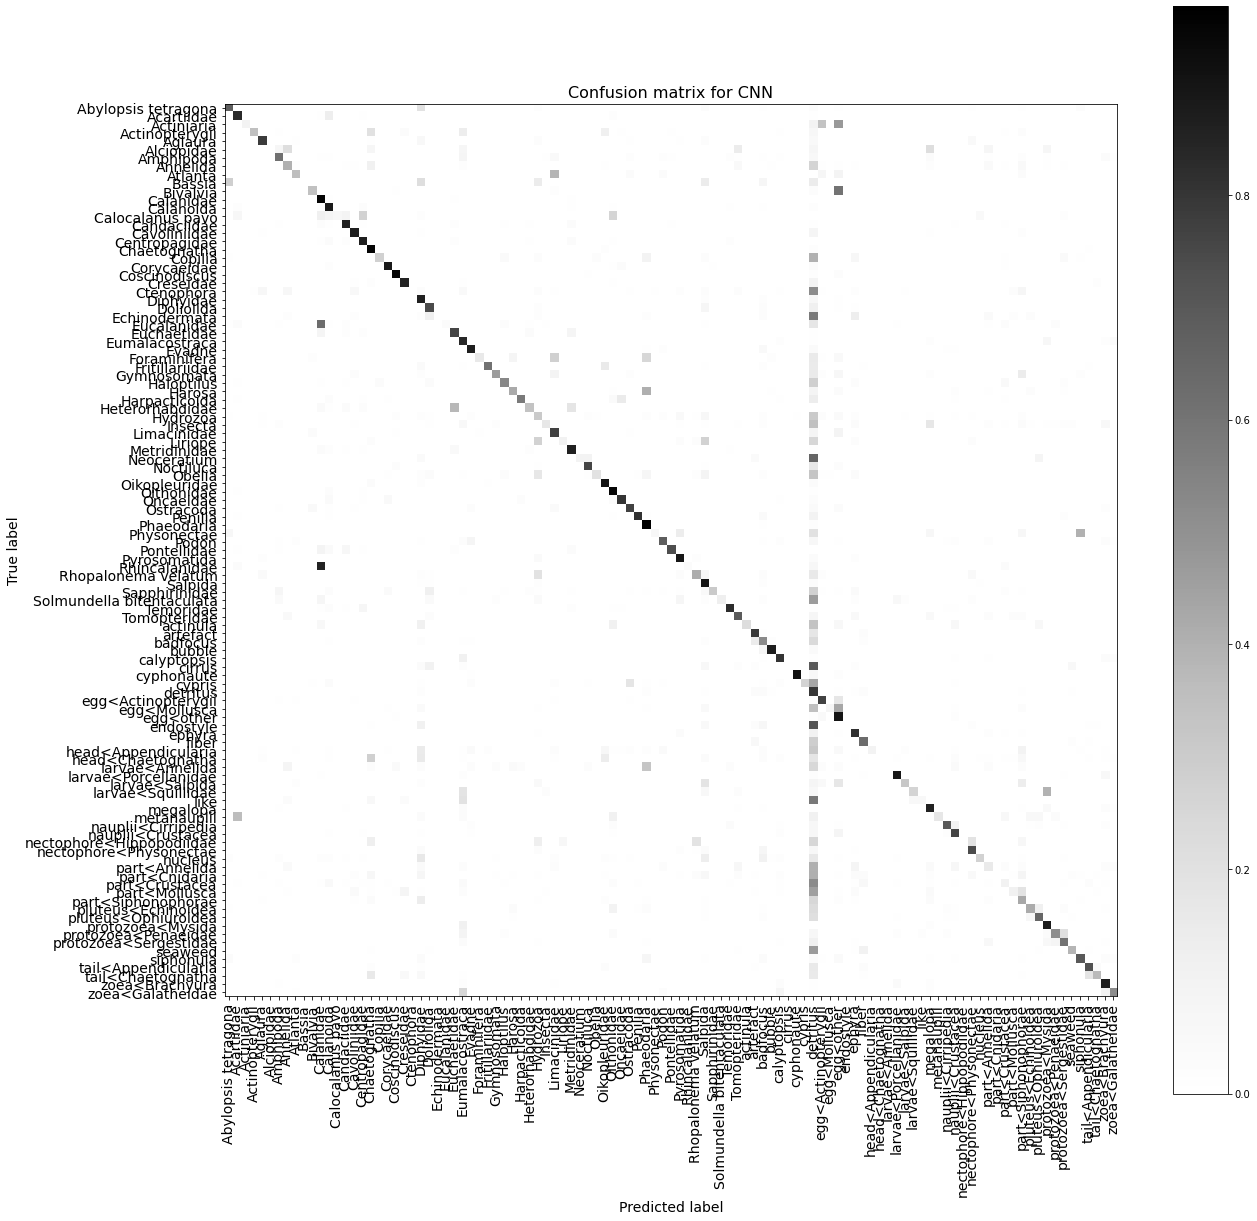

In [26]:
# Create confution matrix
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Plot if
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap='Greys')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
plt.yticks(tick_marks, classes, fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title("Confusion matrix for CNN", fontsize=16)
plt.show()

### Classification report

Plot a classification report

/home/tpanaiotis/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


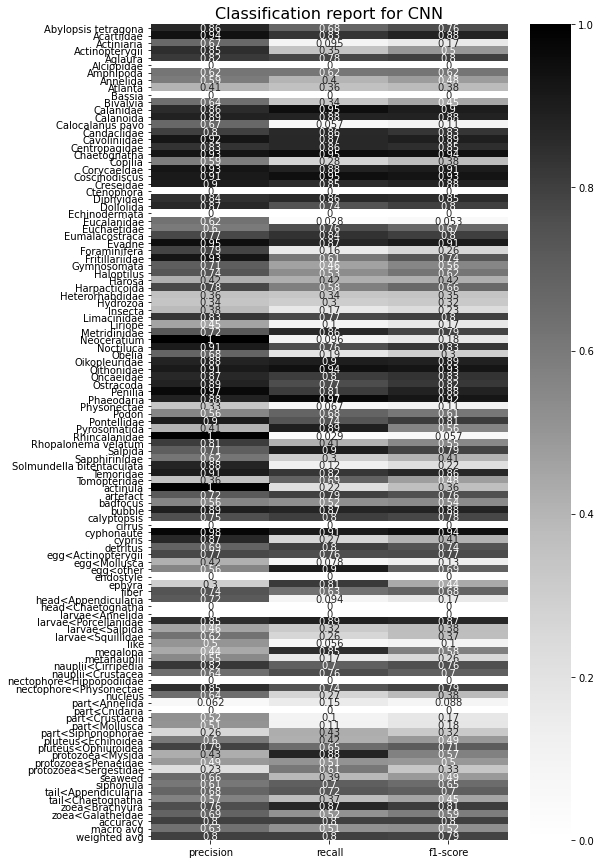

In [27]:
# Create classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

# List annotations for figure
annot = [str(x) for x in classes]
annot.extend(("accuracy", "macro avg", "weighted avg"))

# Convert report to dataframe
df_report = pd.DataFrame(report).transpose().drop('support', axis=1)

# Plot figure
plt.figure(figsize = (8,15))
sn.heatmap(df_report, annot=True, vmin=0, vmax=1.0,  yticklabels = annot, cmap="Greys")
plt.title("Classification report for CNN", fontsize=16)
plt.show()